
=== FSX ===
Validation Accuracy: 0.944
[[11  1]
 [ 0  6]]


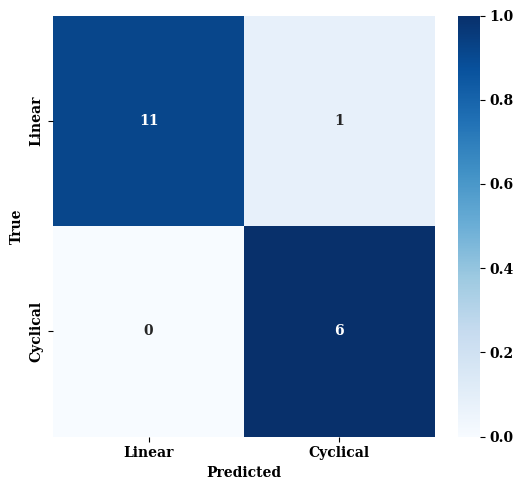

Misclassified samples:
A0A6C0M6B5_L	True: 0	Pred: 1	Conf: 97.9%


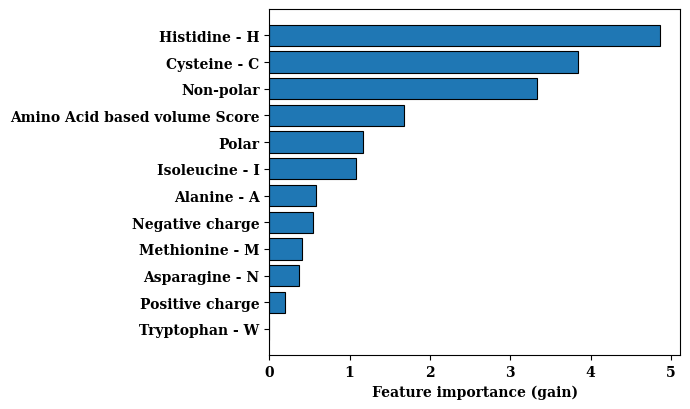

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

TRAIN_CSV = 'TestTrain.csv'
VAL_CSV   = 'ValidationSet.csv'
TARGET_COL = 'Cyclical'
BASE_SEED = 42
DPI_SAVE = 600

CONF_PNG    = 'confmatrix_{key}.png'
FEATIMP_PNG = 'featimp_{key}.png'

train_df = pd.read_csv(TRAIN_CSV)
val_df   = pd.read_csv(VAL_CSV)

if TARGET_COL not in train_df.columns or TARGET_COL not in val_df.columns:
    raise KeyError(f"Missing target column '{TARGET_COL}' in one of the datasets")

y_train = train_df[TARGET_COL].astype(int)
y_val   = val_df[TARGET_COL].astype(int)

FS = {
    'FSX': [
        'Alanine - A', 'Methionine - M', 'Tryptophan - W', 'Isoleucine - I',
        'Cysteine - C', 'Histidine - H', 'Asparagine - N',
        'Positive charge', 'Negative charge', 'Polar', 'Non-polar',
        'Amino Acid based volume Score'
    ],
}

def present_columns_both(cols, df1, df2):
    present = [c for c in cols if (c in df1.columns and c in df2.columns)]
    if not present: print("[WARN] No requested columns present in both datasets.")
    return present

def make_model(seed=BASE_SEED):
    return XGBClassifier(
        eval_metric='logloss', reg_alpha=0.1, reg_lambda=1.0,
        verbosity=0, random_state=seed, use_label_encoder=False,
        tree_method='hist', device='cpu', learning_rate=0.1
    )

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif']  = ['DejaVu Serif']
plt.rcParams['font.weight'] = 'bold'

for key, feature_list in FS.items():
    use_cols = present_columns_both(feature_list, train_df, val_df)
    if not use_cols: continue

    X_train = train_df[use_cols].copy()
    X_val   = val_df[use_cols].copy()

    class_weights = y_train.value_counts(normalize=True).to_dict()
    weight_map = {k: 1.0 / v for k, v in class_weights.items()}
    sample_weights_train = y_train.map(weight_map).values

    model = make_model()
    model.fit(X_train, y_train, sample_weight=sample_weights_train)

    proba = model.predict_proba(X_val)[:, 1]
    pred  = (proba >= 0.5).astype(int)
    acc = accuracy_score(y_val, pred)
    cm  = confusion_matrix(y_val, pred, labels=[0, 1])

    print(f"\n=== {key} ===")
    print(f"Validation Accuracy: {acc:.3f}")
    print(cm)

    cm_norm = cm / cm.sum(axis=1, keepdims=True)
    fig, ax = plt.subplots(figsize=(5.5, 5))
    sns.heatmap(cm_norm, annot=cm, fmt='d', cmap='Blues', vmin=0, vmax=1,
                xticklabels=['Linear', 'Cyclical'], yticklabels=['Linear', 'Cyclical'], ax=ax)
    ax.set_xlabel('Predicted', fontweight='bold')
    ax.set_ylabel('True', fontweight='bold')
    plt.tight_layout()
    plt.savefig(CONF_PNG.format(key=key), dpi=DPI_SAVE, bbox_inches='tight', pad_inches=0.1)
    plt.show()

    ids = val_df["Protein"].astype(str).values if "Protein" in val_df.columns else np.arange(len(y_val)).astype(str)
    misses = []
    for i, (t, p, pr) in enumerate(zip(y_val, pred, proba)):
        if int(t) != int(p):
            conf = max(pr, 1 - pr) * 100
            misses.append((ids[i], int(t), int(p), round(conf, 1)))

    if misses:
        print("Misclassified samples:")
        for obs, t, p, conf in sorted(misses, key=lambda x: -x[3]):
            print(f"{obs}\tTrue: {t}\tPred: {p}\tConf: {conf}%")
    else:
        print("No misclassified validation samples.")

    gain_map = model.get_booster().get_score(importance_type='gain')
    if gain_map and all(k.startswith('f') and k[1:].isdigit() for k in gain_map.keys()):
        idx_map = {f"f{i}": col for i, col in enumerate(X_train.columns)}
        gain_map = {idx_map[k]: v for k, v in gain_map.items() if k in idx_map}
    gains = {col: float(gain_map.get(col, 0.0)) for col in X_train.columns}

    order = sorted(gains, key=gains.get, reverse=True)
    vals  = [gains[f] for f in order]
    fig, ax = plt.subplots(figsize=(7, max(4, 0.35 * len(order))))
    ax.barh(order, vals, edgecolor='black', linewidth=0.8)
    ax.invert_yaxis()
    ax.set_xlabel('Feature importance (gain)', fontweight='bold')
    plt.tight_layout()
    plt.savefig(FEATIMP_PNG.format(key=key), dpi=DPI_SAVE, bbox_inches='tight', pad_inches=0.1)
    plt.show()
